# Example for the QuaSiModO algorithm

## Open loop control and MPC for the Duffing equation with EDMD surrogate modeling

This standalone script demonstrates the QuaSiModO procedure in open and closed-loop form for the Duffing equation using [**Extended Dynamic Mode Decomposition (EDMD)**](https://link.springer.com/article/10.1007/s00332-015-9258-5) as the surrogate modeling technique.

To *simplify the implementation*, the number of discrete controls in $V$is fixed to two (by which $\alpha$ is one-dimensional).

**Authors**: Sebastian Peitz & Katharina Bieker *(Department of Mathematics, Paderborn University)*

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from scipy.linalg import pinv
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.special import binom

# some stuff for nice plots
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16}
font = {'size': 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True

Define the right-hand side of the duffing equation

\begin{equation} 
\dot{x} = \begin{pmatrix} x_2 \\ - \delta x_2 -\alpha x_1 - \beta x_1^3 + u  \end{pmatrix},
\end{equation}

with $\alpha = -1$, $\beta = 1$ and $\delta = -0.1$.

In [2]:
def rhs(y_, u_):
    alpha, beta, delta = -1.0, 1.0, -0.1
    return np.array([y_[1], -delta * y_[1] - alpha * y_[0] - beta * y_[0] * y_[0] * y_[0] + u_])

## Numerical setup

Definition of the numerical discretization and surrogate model, the most important being

* size of the *fine* time step $h$ (for numerical integration) and *coarse* time step $dt = facU \cdot h$ for the time-T- maps $\Phi$ and $\Phi^r$,
* control set $U=[u_{min},u_{max}]$ with boundaries $u_{min}$ and $u_{max}$ as well as the finite set $V=\{u_{min},u_{max}\}$,
* reference trajectory $y_{ref}$ (and analogously $y_{ref,2}$ on coarse grid) and weight $Q$ in the objective function.

Finally, a helper function mapping solutions from the coarse to the fine time grid is defined

In [23]:
h = 1e-2                        # Time step of integrator
facU = 1                        # Factor by which dt is larger
dt = facU * h                   # Coarse time step for SUR
T = 1.0                         # Final time
dimY = 2                        # dimension of state space

u_min = -10.0                   # lower bound for control
u_max = 10.0                    # upper bound for control

V = [u_min, u_max]              # finite set of admissible controls in (II) and (III)
nu = len(V)                     # dimension of V

Q = [1.0, 0.1]                  # weights on the diagonal of the Q-matrix in the objective function

y0 = [1.0, 0.0]                 # initial condition for y

nt = round(T / h) + 1           # number of time steps on fine grid
nt2 = round(T / dt) + 1         # number of time steps on coarser grid for SUR

t = np.linspace(0.0, T, nt)     # array of time steps (fine grid)
t2 = np.linspace(0.0, T, nt2)   # array of time steps (coarse grid)

u0 = np.zeros(nt,)              # initial guess for control u

y_ref = np.zeros((nt, 2))       # reference trajectory on fine grid
y_ref2 = y_ref[::facU, :]       # reference trajectory on coarse grid


def coarseGridToFine(x_):
    if facU == 1:
        return x_
    y_ = np.zeros(nt, dtype=float)
    for ii in range(nt2 - 1):
        y_[facU * ii: facU * (ii + 1)] = x_[ii]
    y_[-1] = x_[-1]
    return y_

Definition of a numerical ODE solver (4th order Runge-Kutta), the time-T-map $\Phi$ and the objective function of *Problem (I)*, i.e., for the full model with continuous inputs:

\begin{equation}
\begin{aligned}
J_I = h \cdot \sum_{i=0}^{n_t-1} (y_i - y_{ref,i})^\top &Q (y_i - y_{ref,i}).
\end{aligned}
\end{equation}

In [24]:
def ODE(u_, y0_):
    y_ = np.zeros((u_.shape[0], dimY), dtype=float)
    y_[0, :] = y0_
    for ii in range(u_.shape[0] - 1):
        k1 = rhs(y_[ii, :], u_[ii])
        k2 = rhs(y_[ii, :] + h / 2 * k1[:], u_[ii])
        k3 = rhs(y_[ii, :] + h / 2 * k2[:], u_[ii])
        k4 = rhs(y_[ii, :] + h * k3[:], u_[ii])
        y_[ii + 1, :] = y_[ii, :] + h / 6 * (k1[:] + 2 * k2[:] + 2 * k3[:] + k4[:])
    return y_


def Phi(u_, y0_):
    # Integration with constant input over one time step of the coarse grid
    u2 = u_ * np.ones((facU + 1), dtype=float)
    y_ = ODE(u2, y0_)
    return y_[-1, :]


def J_I(u_):
    dy = ODE(u_, y0) - y_ref
    dyQ = np.zeros(dy.shape[0], dtype=float)
    for ii in range(dy.shape[1]):
        dyQ += Q[ii] * np.power(dy[:, ii], 2)

    return h * np.sum(dyQ)

## Data collection

In [25]:
y_min = [-2.0, -2.0]    # lower left corner for box of random initial conditions
y_max = [2.0, 2.0]      # upper right corner for box of random initial conditions
nData = 10000           # number of random initial conditions

# Create nData random initial conditions ...
X = np.ones((dimY, nData), dtype=float)
for i in range(dimY):
    X[i, :] *= y_min[i] + (y_max[i] - y_min[i]) * np.random.rand(nData)

# ... and evaluate Phi for all controls in V
Y = np.zeros((dimY, nData, nu), dtype=float)
for j in range(nu):
    for i in range(nData):
        Y[:, i, j] = Phi(V[j], X[:, i])

## Surrogate modeling

Calculate the individual Koopman operator approximations $K_{u^j}$ for all $u^j \in V$ via EDMD using a polynomial dictionary $\psi$ of a given maximum order.

In [26]:
# maximum order of polynomial terms in the EDMD algorithm
maxOrderEDMD = 3

# The function lifts the input matrix X to PsiX, containing polynomials of up to order maxOrderEDMD.
# The array iy denotes the indices for projecting PsiX to X.
# If maxOrderEDMD is set to zero, then PsiX = X, meaning that we use DMD.
def psi(X_, returnProjection=False):
    if maxOrderEDMD == 0:
        iy_ = [0, 1]
        if returnProjection:
            return X_, iy_
        else:
            return X_
    else:
        if len(np.array(X_).shape) == 1:
            X_ = np.array([X_]).T
        nPoly = int(binom(2 + maxOrderEDMD, maxOrderEDMD))
        PsiX_ = np.ones((nPoly, X_.shape[1]), dtype=float)
        PsiX_[1: 3, :] = X_

        s = 3
        for jj in range(2, maxOrderEDMD + 1):
            for ii in range(jj + 1):
                PsiX_[s, :] = np.power(X_[1, :], ii) * np.power(X_[0, :], jj - ii)
                s += 1

        iy_ = [1, 2]
        if returnProjection:
            return PsiX_, iy_
        else:
            return PsiX_


PsiX, iy = psi(X, True)             # Lift X to PsiX
G = PsiX @ PsiX.T                   # define G-Matrix for EDMD

dimZ = PsiX.shape[0]                # dimension of the lifted state

# Compute Koopman matrices for the individual systems wit fixed controls u in V
K = np.zeros((dimZ, dimZ, nu), dtype=float)
for i in range(nu):
    PsiY = psi(Y[:, :, i])          # Lift Y to PsiY
    Ai = PsiX @ PsiY.T              # Define A-matrix for i-th system in V for EDMD
    K[:, :, i] = (pinv(G) @ Ai).T   # Calculate K for the i-th system

# calculate lifted initial condition z0
z0 = y0  # psi(y0)[:, 0]

For the solution of *Problems (III)* and *(IV)*, we define the surrogate model $\Phi^r$, i.e., 

\begin{equation}
\begin{aligned}
z_{i+1} = \Phi^r(z_i, u_i) = \alpha_i K_{u^0} z_i + (1 - \alpha_i) K_{u^1} z_i = \left(\alpha_i K_{u^0} + (1 - \alpha_i) K_{u^1}\right) z_i,
\end{aligned}
\end{equation}

the objective function $J^r$ and the sum-up rounding procedure according to [Sager, Bock & Diehl, The integer approximation error in mixed-integer optimal control, Mathematical Programming 133, 1-23, 2012.](https://link.springer.com/article/10.1007/s10107-010-0405-3)

In [27]:
def ROM(alpha_, z0_):
    z_ = np.zeros((alpha_.shape[0], len(z0_)), dtype=float)
    z_[0, :] = z0_

    # state at next time step is computed via a convex combination of the autonomous systems
    for ii in range(alpha_.shape[0] - 1):
        z_[ii + 1, :] += ((alpha_[ii] * K[:, :, 0] + (1.0 - alpha_[ii]) * K[:, :, 1]) @ psi(z_[ii, :]))[iy, 0]
    return z_


def J_IV(alpha_):
    z_ = ROM(alpha_, z0)
    dz = z_ - y_ref2
    dzQ = np.zeros(dz.shape[0], dtype=float)
    for ii in range(dz.shape[1]):
        dzQ += Q[ii] * np.power(dz[:, ii], 2)

    return dt * np.sum(dzQ)


def SUR(alpha_):
    omega = np.zeros((nt2, nu), dtype=float)
    omegaHat = np.zeros(nu)
    for ii in range(nt2):
        for jj in range(nu - 1):
            omegaHat[jj] = np.sum(alpha_[:ii + 1]) - np.sum(omega[:ii, jj])
        omegaHat[-1] = np.sum(1.0 - alpha_[:ii + 1]) - np.sum(omega[:ii, -1])
        iOut = np.argmax(omegaHat)
        omega[ii, iOut] = 1.0
    u2 = np.zeros(nt2, dtype=float)
    for ii in range(nt2):
        for jj in range(nu):
            u2[ii] += omega[ii, jj] * V[jj]
    return u2

## Compare the full model and the surrogate model using a random input sequence

In [28]:
# create random control input via a random alpha trajectory
alpha_test2 = np.random.rand(nt2)
u_test2 = V[0] * alpha_test2 + V[1] * (np.ones(nt2, dtype=float) - alpha_test2)
u_test = coarseGridToFine(u_test2)

# simulate both ODE and ROM
y_test = ODE(u_test, y0)
z_test = ROM(alpha_test2, z0)

Visualize the two trajectories and their difference

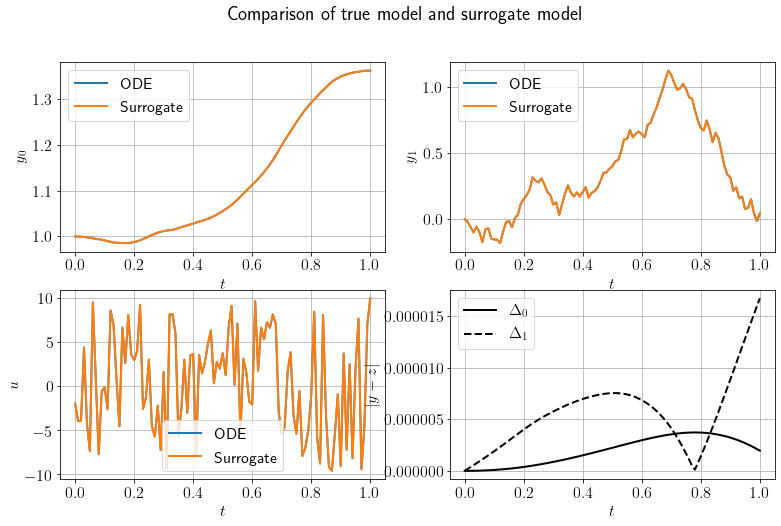

In [29]:
fig = plt.figure(figsize=[12.80, 7.68])
ax = list()
ax.append(fig.add_subplot(2, 2, 1))
ax.append(fig.add_subplot(2, 2, 2))
ax.append(fig.add_subplot(2, 2, 3))
ax.append(fig.add_subplot(2, 2, 4))
ax[0].plot(t, y_test[:, 0], linewidth=2, color='tab:blue', linestyle='solid', label=r'ODE')
ax[0].plot(t2, z_test[:, 0], linewidth=2, color='tab:orange', linestyle='solid', label=r'Surrogate')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$y_0$')
ax[0].grid()
ax[0].legend()
ax[1].plot(t, y_test[:, 1], linewidth=2, color='tab:blue', linestyle='solid', label=r'ODE')
ax[1].plot(t2, z_test[:, 1], linewidth=2, color='tab:orange', linestyle='solid', label=r'Surrogate')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$y_1$')
ax[1].grid()
ax[1].legend()
ax[2].plot(t, u_test, linewidth=2, color='tab:blue', linestyle='solid', label=r'ODE')
ax[2].plot(t2, u_test2, linewidth=2, color='tab:orange', linestyle='solid', label=r'Surrogate')
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$u$')
ax[2].grid()
ax[2].legend()
ax[3].plot(t2, np.absolute(y_test[::facU, 0]-z_test[:, 0]), linewidth=2, color='k', linestyle='solid', label=r'$\Delta_0$')
ax[3].plot(t2, np.absolute(y_test[::facU, 1]-z_test[:, 1]), linewidth=2, color='k', linestyle='dashed', label=r'$\Delta_1$')
ax[3].set_xlabel(r'$t$')
ax[3].set_ylabel(r'$|y - z|$')
ax[3].grid()
ax[3].legend()
fig.suptitle(r'Comparison of true model and surrogate model')
plt.show()

## Open loop optimal control

Solve *Problem (I)* on the fine grid:

\begin{equation}
\begin{aligned}
    \min_{u\in U^{n_t}} h \cdot &\sum_{i=0}^{n_t-1} (y_i - y_{ref,i})^\top Q (y_i - y_{ref,i}) \\
    &\mbox{s.t.} \quad y_{i+1} = \Phi(y_i, u_i).
\end{aligned}
\end{equation}

In [30]:
# box constraints u_min <= u <= u_max
bounds = Bounds(u_min * np.ones(nt, dtype=float), u_max * np.ones(nt, dtype=float))

# call optimizer
print('Solve optimization problem (I) with T = {:.1f} ...'.format(T))
t0 = time.time()
res = minimize(J_I, u0, method='SLSQP', bounds=bounds, options={'ftol': 1e-12})
tI = time.time() - t0
print('-> Done in {:.2f} seconds.\n'.format(tI))

# extract u, J and calculate y
JI_opt = res.fun
uI_opt = res.x
yI_opt = ODE(uI_opt, y0)

Solve optimization problem (I) with T = 1.0 ...
-> Done in 25.29 seconds.



Now solve Problem (IV) on the coarse grid:

\begin{equation}
    \begin{aligned}
        \min_{\alpha\in [0,1]^{n_{t,2}}} &dt \cdot \sum_{i=0}^{n_{t,2}-1} (Pz_i - y_{ref,i})^\top Q (Pz_i - y_{ref,i}) \\
        \mbox{s.t.} \quad z_{i+1} &= \Phi^r(z_i, \alpha_i) =\alpha_{i} \Phi^r_{u^1}(z_i) + (1-\alpha_{i}) \Phi^r_{u^0}(z_i),
    \end{aligned}
\end{equation}

where $Pz$ projects the lifted state $z=\psi(y)$ back to $y$.

In [31]:
# initial value for alpha on coarse grid
alpha02 = 0.5 * np.ones(nt2, dtype=float)

# alpha is bounded between 0 and 1
bounds = Bounds(0.0 * np.ones(nt2, dtype=float), 1.0 * np.ones(nt2, dtype=float))

# call optimizer
print('Solve optimization problem (IV) with T = {:.1f} ...'.format(T))
t0 = time.time()
res = minimize(J_IV, alpha02, method='SLSQP', bounds=bounds, options={'ftol': 1e-12})
tIV = time.time() - t0
print('-> Done in {:.2f} seconds. Speedup factor versus (I): {:.2f}.\n'.format(tIV, tI/tIV))

# extract alpha and J
JIV_opt = res.fun
alpha_opt2 = res.x

# in the continuous case, u is obtaind by a convex combination of the entries in V and using alpha
uIV_opt2 = alpha_opt2 * V[0] + (1.0 - alpha_opt2) * V[1]
uIV_opt = coarseGridToFine(uIV_opt2)
yIV_opt = ODE(uIV_opt, y0)

Solve optimization problem (IV) with T = 1.0 ...
-> Done in 62.79 seconds. Speedup factor versus (I): 0.40.



Calculate the solution to Problem (III) by rounding the solution to (IV)

In [32]:
# in the mixed-integer case, u is in V at all times, which is ensured by sum-up rounding
uIII_opt2 = SUR(alpha_opt2)
uIII_opt = coarseGridToFine(uIII_opt2)
yIII_opt = ODE(uIII_opt, y0)

Compare the optimal solutions $J(S(u^*_{(I)})$, $J(S(u^*_{(IV)})$ and $J(S(u^*_{(III)})$. With an exact solution, we would have
\begin{equation}
    \left|J(S(u^*_{(IV)}) - J(S(u^*_{(I)}) \right| > 0 \quad \mbox{and} \quad \left|J(S(u^*_{(III)}) - J(S(u^*_{(I)}) \right|>0.
\end{equation}
However, it appears that the _SciPy_ solver __minimize__ works better for the surrogate problem that is bounded between 0 and 1.

In [40]:
JSuI = J_I(uI_opt)
JSuIV = J_I(uIV_opt)
JSuIII = J_I(uIII_opt)
print('J( S(uI) ) = {}'.format(JSuI))
print('J( S(uIV)) = {}'.format(JSuIV))
print('J(S(uIII)) = {}\n'.format(JSuIII))
print('|J( S(uIV)) - J(S(uI))| = {}'.format(JSuIV - JSuI))
print('|J(S(uIII)) - J(S(uI))| = {}\n'.format(JSuIII-JSuI))

J( S(uI) ) = 0.40874362693668526
J( S(uIV)) = 0.4067375892850672
J(S(uIII)) = 0.40699433571593163

|J( S(uIV)) - J(S(uI))| = -0.0020060376516180534
|J(S(uIII)) - J(S(uI))| = -0.0017492912207536238



## Approximate error bound

Here, we calculate a numerical approximation for the error bound, using as $E$ the maximum errors obtained in the training data set. Note that based on the above observation that the surrogate-based optimium is superior, the bound is likely to be violated.

In [45]:
gX = np.zeros(Y.shape)
gY = np.zeros(Y.shape)
for j in range(nu):
    for i in range(nData):
        gX[:, i, j] = rhs(X[:, i], V[j])
        gY[:, i, j] = rhs(Y[:, i, j], V[j])
C1 = [np.max(np.max(np.absolute((gY[:, :, 0] - gX[:, :, 0]) / dt))), np.max(np.max(np.absolute((gY[:, :, 1] - gX[:, :, 1]) / dt)))]
C2 = [np.max(np.max(np.absolute((Y[:, :, 0] - X) / dt))), np.max(np.max(np.absolute((Y[:, :, 1] - X) / dt)))]

C1 = np.max(C1)
C2 = np.max(C2)

L = C2

# Create new data for validation
nDataTest = 10000
X = np.ones((dimY, nDataTest), dtype=float)
for i in range(dimY):
    X[i, :] *= y_min[i] + (y_max[i] - y_min[i]) * np.random.rand(nDataTest)
Y = np.zeros((dimY, nDataTest, nu), dtype=float)
for j in range(nu):
    for i in range(nDataTest):
        Y[:, i, j] = Phi(V[j], X[:, i])

# Estimate error bound by maximal error over test data set
E = np.zeros(nu)
for j in range(nu):
    E[j] = np.max(np.linalg.norm(Y[:, :, j] - (K[:, :, j] @ psi(X))[iy, :], ord=np.inf, axis=1))
E = np.max(E)
print('Estimated error bound: E ={}'.format(E))

# Estimate lipschitz constant of objective function P
L = 2 * h * np.sum(yI_opt[:, 0] * Q[0] + yI_opt[:, 1] * Q[1])
print('Estimated Lipschitz constant for the objective function: L ={}'.format(L))

# Bounds M1 and M2
M1 = 0.0
M2 = (C2 + C1 * T) * float(nu - 1) * dt

eLdt = np.exp(L * dt)

# Model error
Emodel = np.zeros(nt2)
for i in range(1, nt2):
    Emodel[i] = (Emodel[i - 1] + E) * eLdt

Ev = M1 * (eLdt * (np.exp(L * t2) - 1.0))/(eLdt - 1)
EMi = M2 * (eLdt * (np.exp(L * t2) - 1.0))/(eLdt - 1)
Er = 2 * L * np.sum(Emodel)

E2 = Emodel + Ev + EMi
E3 = Emodel + Ev

EJ2b = Er + Ev[-1] + EMi[-1]
EJ3 = Er + Ev[-1]

print('Error bound for the objective function: (E2b) ={}'.format(EJ2b))
print('Error bound for the objective function: (E3) ={}'.format(EJ3))

Estimated error bound: E =2.1450097928976675e-06
Estimated Lipschitz constant for the objective function: L =0.7345612265484236
Error bound for the objective function: (E2b) =57.40302446548907
Error bound for the objective function: (E3) =0.02075016319054304


## Visualize the different open loop solutions and error bounds

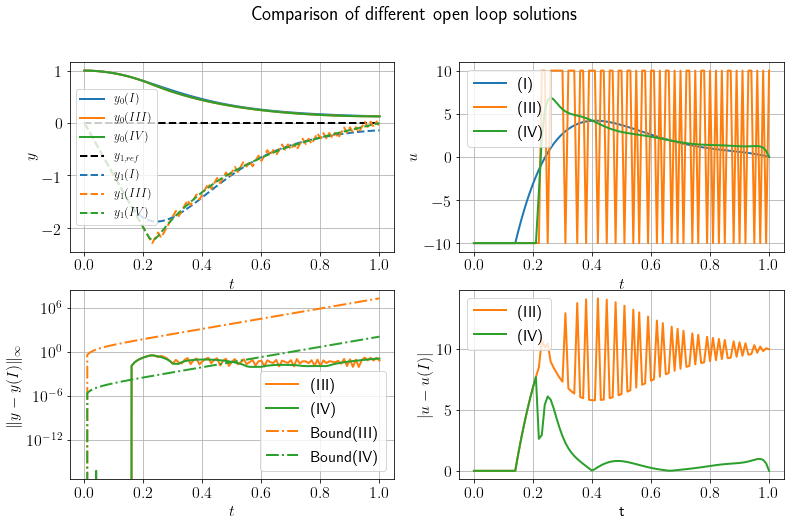

In [42]:
fig = plt.figure(figsize=[12.80, 7.68])
ax = list()
ax.append(fig.add_subplot(2, 2, 1))
ax.append(fig.add_subplot(2, 2, 2))
ax.append(fig.add_subplot(2, 2, 3))
ax.append(fig.add_subplot(2, 2, 4))
ax[0].plot(t, yI_opt[:, 0], linewidth=2, color='tab:blue', linestyle='solid', label=r'$y_0(I)$')
ax[0].plot(t, yIII_opt[:, 0], linewidth=2, color='tab:orange', linestyle='solid', label=r'$y_0(III)$')
ax[0].plot(t, yIV_opt[:, 0], linewidth=2, color='tab:green', linestyle='solid', label=r'$y_0(IV)$')
ax[0].plot(t, y_ref[:, 1], linewidth=2, color='k', linestyle='dashed', label=r'$y_{1,ref}$')
ax[0].plot(t, yI_opt[:, 1], linewidth=2, color='tab:blue', linestyle='dashed', label=r'$y_1(I)$')
ax[0].plot(t, yIII_opt[:, 1], linewidth=2, color='tab:orange', linestyle='dashed', label=r'$y_1(III)$')
ax[0].plot(t, yIV_opt[:, 1], linewidth=2, color='tab:green', linestyle='dashed', label=r'$y_1(IV)$')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$y$')
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].plot(t, uI_opt, linewidth=2, color='tab:blue', linestyle='solid', label=r'(I)')
ax[1].plot(t, uIII_opt, linewidth=2, color='tab:orange', linestyle='solid', label=r'(III)')
ax[1].plot(t, uIV_opt, linewidth=2, color='tab:green', linestyle='solid', label=r'(IV)')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$u$')
ax[1].grid()
ax[1].legend()
ax[2].plot(t, np.linalg.norm(yI_opt - yIII_opt, ord=np.inf, axis=1), linewidth=2, color='tab:orange', linestyle='solid', label=r'(III)')
ax[2].plot(t, np.linalg.norm(yI_opt - yIV_opt, ord=np.inf, axis=1), linewidth=2, color='tab:green', linestyle='solid', label=r'(IV)')
ax[2].plot(t2, E2, linewidth=2, color='tab:orange', linestyle='dashdot', label=r'Bound(III)')
ax[2].plot(t2, E3, linewidth=2, color='tab:green', linestyle='dashdot', label=r'Bound(IV)')
# ax[2].set_ylim((0, np.max(np.linalg.norm(yI_opt - yIII_opt, ord=np.inf, axis=1))))
# ax[2].set_xlim((t2[0], t2[-1]))
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$\|y - y(I)\|_{\infty}$')
ax[2].grid()
ax[2].legend()
ax[3].plot(t, np.absolute(uIII_opt - uI_opt), linewidth=2, color='tab:orange', linestyle='solid', label=r'(III)')
ax[3].plot(t, np.absolute(uIV_opt - uI_opt), linewidth=2, color='tab:green', linestyle='solid', label=r'(IV)')
ax[3].set_xlabel(r't')
ax[3].set_ylabel(r'$|u - u(I)|$')
ax[3].grid()
ax[3].legend()
fig.suptitle(r'Comparison of different open loop solutions')
plt.show()

## MPC

Now, we do the same for feedback control using MPC. To this end, we need to redefine the objective functions J to shorter reference trajectories of variable length $p$. We then solve the above open-loop problem repeatedly and always apply the first entry $u_0$ to the plan.

We begin with the full model in the control problem.

In [16]:
p = 20                               # Prediction horizon on coarse grid
T = 10.0                             # New final time
nt2 = round(T / dt) + 1              # number of time steps on coarser grid for SUR
t2 = np.linspace(0.0, T, nt2)        # array of time steps (coarse grid)

# new reference trajectory
y_ref2 = np.zeros((nt2, 2))
y_ref2[np.where(t2 <= 8.0), 0] = -0.5
y_ref2[np.where(t2 <= 6.0), 0] = 0.5
y_ref2[np.where(t2 <= 4.0), 0] = -1.0
y_ref2[np.where(t2 <= 2.0), 0] = 1.0

print('Solve (I) via MPC with T = {:.1f} ...'.format(T))


# Refdefine J_I with shorter reference trajectory
def J_I_MPC(u_, y0_, y_ref_):

    # calculate trajectory using the time-T-map Phi
    y_ = np.zeros((p + 1, 2))
    y_[0, :] = y0_
    for ii in range(p):
        y_[ii + 1, :] = Phi(u_[ii], y_[ii, :])

    # fill up reference trajectory if necessary
    y_ref_2 = np.zeros(y_.shape)
    y_ref_2[:y_ref_.shape[0], :] = y_ref_

    # calculate weighted difference between trajectories
    dy = y_ - y_ref_2
    dyQ = np.zeros(dy.shape[0], dtype=float)
    for ii in range(dy.shape[1]):
        dyQ += Q[ii] * np.power(dy[:, ii], 2)

    return dt * np.sum(dyQ)


# initialize arrays for MPC solution
yI_MPC = np.zeros((nt2, 2))
yI_MPC[0, :] = y0
uI_MPC = np.zeros(nt2)

# initial guess for first optimization problem
u0 = 0.5 * (u_max + u_min) * np.ones(p) + 0.1 * (np.random.rand(p) - 0.5) * (u_max - u_min)

# box constraints u_min <= u <= u_max
bounds = Bounds(u_min * np.ones(p, dtype=float), u_max * np.ones(p, dtype=float))

# MPC loop
t0 = time.time()
for i in range(nt2):

    # determine maximum entry of reference trajectory
    # if ie - i < p, then the remaining entries are
    # constant and identical to the last given one
    ie = np.min([nt2, i + p + 1])

    # call optimizer
    res = minimize(lambda utmp: J_I_MPC(utmp, yI_MPC[i, :], y_ref2[i: ie, :]), u0, method='SLSQP', bounds=bounds)

    # retreive first entry of u and apply it to the plant
    uI_MPC[i] = res.x[0]
    if i < nt2 - 1:
        yI_MPC[i + 1, :] = Phi(uI_MPC[i], yI_MPC[i, :])

    # update initial guess
    u0[:-1] = res.x[1:]
    u0[-1] = res.x[-1]
    
tI_MPC = time.time() - t0
print('-> Done in {:.2f} seconds.\n'.format(tI_MPC))

Solve (I) via MPC with T = 10.0 ...
-> Done in 17.41 seconds.



Now perform MPC using the surrogate model with continuous inputs, i.e., *Problem (IV)*.

In [17]:
# Refdefine J_IV with shorter reference trajectory
def J_IV_MPC(alpha_, y0_, y_ref_):

    # lift initial condition
    z0_ = psi(y0_)[:, 0]

    # simluate ROM
    z_ = ROM(np.concatenate((alpha_, [0.0])), z0_)

    # fill up reference trajectory if necessary
    y_ref_2 = np.zeros((z_.shape[0], y_ref_.shape[1]))
    y_ref_2[:y_ref_.shape[0], :] = y_ref_

    # calculate weighted difference between trajectories
    dz = z_[:, iy] - y_ref_2
    dzQ = np.zeros(dz.shape[0], dtype=float)
    for ii in range(dz.shape[1]):
        dzQ += Q[ii] * np.power(dz[:, ii], 2)

    return dt * np.sum(dzQ)


# initialize arrays for MPC solution
yIV_MPC = np.zeros((nt2, 2))
yIV_MPC[0, :] = y0
uIV_MPC = np.zeros(nt2)

# initial guess for first optimization problem
alpha0 = 0.5 * np.ones(p)

# alpha is bounded between 0 and 1
bounds = Bounds(0.0 * np.ones(p, dtype=float), 1.0 * np.ones(p, dtype=float))

# MPC loop
print('Solve (IV) via MPC with T = {:.1f} ...'.format(T))
t0 = time.time()
for i in range(nt2):

    # determine maximum entry of reference trajectory
    # if ie - i < p, then the remaining entries are
    # constant and identical to the last given one
    ie = np.min([nt2, i + p + 1])

    # call optimizer
    res = minimize(lambda alpha: J_IV_MPC(alpha, yIV_MPC[i, :], y_ref2[i: ie, :]), alpha0, method='SLSQP', bounds=bounds)

    # retreive first entry of u and apply it to the plant
    uIV_MPC[i] = res.x[0] * V[0] + (1.0 - res.x[0]) * V[1]
    if i < nt2 - 1:
        yIV_MPC[i + 1, :] = Phi(uIV_MPC[i], yIV_MPC[i, :])

    # update initial guess
    alpha0[:-1] = res.x[1:]
    alpha0[-1] = res.x[-1]
    
tIV_MPC = time.time() - t0
print('-> Done in {:.2f} seconds. Speedup factor versus (I): {:.2f}.\n'.format(tIV_MPC, tI_MPC / tIV_MPC))


Solve (IV) via MPC with T = 10.0 ...


ValueError: could not broadcast input array from shape (21,1) into shape (2,1)

Finally, we do the third MPC loop using the rounded optimal solution (i.e., *Problem (III)*)

In [ ]:
# The optimization problem we solve is identical to (IV), but the
# plant behavior may be different, as we apply rounded inputs to
# the plant, which result in different initial conditions for the
# consecutive optimization problem.


# sum-up rounding for MPC, taking all past decisions into account
def SUR_MPC(alpha_, omega_, u_, it):
    omegaHat = np.zeros(nu)
    for jj in range(nu - 1):
        omegaHat[jj] = np.sum(alpha_[:it + 1]) - np.sum(omega_[:it, jj])
        omegaHat[-1] = np.sum(1.0 - alpha_[:it + 1]) - np.sum(omega_[:it, -1])
        iOut = np.argmax(omegaHat)
        omega_[it, iOut] = 1.0
    for jj in range(nu):
        u_[it] += omega_[it, jj] * V[jj]
    return alpha_, omega_, u_


# initialize arrays for MPC solution
yIII_MPC = np.zeros((nt2, 2))
yIII_MPC[0, :] = y0
uIII_MPC = np.zeros(nt2)
alphaIII_MPC = np.zeros(nt2)
omegaIII_MPC = np.zeros((nt2, 2))

# initial guess for first optimization problem
alpha0 = 0.5 * np.ones(p)

# alpha is bounded between 0 and 1
bounds = Bounds(0.0 * np.ones(p, dtype=float), 1.0 * np.ones(p, dtype=float))

# MPC loop
print('Solve (III) via MPC with T = {:.1f} ...'.format(T))
t0 = time.time()
for i in range(nt2):

    # determine maximum entry of reference trajectory
    # if ie - i < p, then the remaining entries are
    # constant and identical to the last given one
    ie = np.min([nt2, i + p + 1])

    # call optimizer
    res = minimize(lambda alpha: J_IV_MPC(alpha, yIII_MPC[i, :], y_ref2[i: ie, :]), alpha0, method='SLSQP', bounds=bounds)

    # retreive first entry of u and apply it to the plant
    alphaIII_MPC[i] = res.x[0]
    alphaIII_MPC, omegaIII_MPC, uIII_MPC = SUR_MPC(alphaIII_MPC, omegaIII_MPC, uIII_MPC, i)
    if i < nt2 - 1:
        yIII_MPC[i + 1, :] = Phi(uIII_MPC[i], yIII_MPC[i, :])

    # update initial guess
    alpha0[:-1] = res.x[1:]
    alpha0[-1] = res.x[-1]
    
tIII_MPC = time.time() - t0
print('-> Done in {:.2f} seconds. Speedup factor versus (I): {:.2f}.\n'.format(tIII_MPC, tI_MPC / tIII_MPC))


Visualize the results.

In [ ]:
fig = plt.figure(figsize=[12.80, 7.68])
ax = list()
ax.append(fig.add_subplot(2, 1, 1))
ax.append(fig.add_subplot(2, 1, 2))
ax[0].plot(t2, y_ref2[:, 0], linewidth=2, color='k', linestyle='solid', label=r'$y_{0,ref}$')
ax[0].plot(t2, yI_MPC[:, 0], linewidth=2, color='tab:blue', linestyle='solid', label=r'$y_0(I)$')
ax[0].plot(t2, yIII_MPC[:, 0], linewidth=2, color='tab:orange', linestyle='solid', label=r'$y_0(III)$')
ax[0].plot(t2, yIV_MPC[:, 0], linewidth=2, color='tab:green', linestyle='solid', label=r'$y_0(IV)$')
ax[0].plot(t2, y_ref2[:, 1], linewidth=2, color='k', linestyle='dashed', label=r'$y_{1,ref}$')
ax[0].plot(t2, yI_MPC[:, 1], linewidth=2, color='tab:blue', linestyle='dashed', label=r'$y_1(I)$')
ax[0].plot(t2, yIII_MPC[:, 1], linewidth=2, color='tab:orange', linestyle='dashed', label=r'$y_1(III)$')
ax[0].plot(t2, yIV_MPC[:, 1], linewidth=2, color='tab:green', linestyle='dashed', label=r'$y_1(IV)$')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$y$')
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].plot(t2, uIII_MPC, linewidth=2, color='tab:orange', linestyle='solid', label=r'(III)')
ax[1].plot(t2, uI_MPC, linewidth=2, color='tab:blue', linestyle='solid', label=r'(I)')
ax[1].plot(t2, uIV_MPC, linewidth=2, color='tab:green', linestyle='solid', label=r'(IV)')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$u$')
ax[1].grid()
ax[1].legend()

fig.suptitle(r'Comparison of different MPC solutions')
plt.show()